<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/MLP_Fmnist_Saver_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# baseline cnn model for fashion mnist
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
seed=5097
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.list_physical_devices('GPU')

[]

In [2]:

number_of_train_examples = 60000 #60000
number_of_test_examples = 10000   #10000

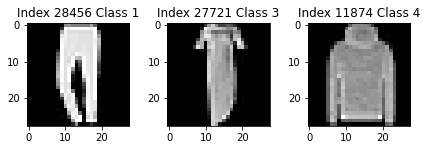

In [3]:
#To load the data set for mist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [4]:
# Split train dataset into train and validation

X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(X_train.shape[0],-1)#.T
X_test = X_test.reshape(X_test.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [5]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

# one hot encode target values
y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val,num_classes=10)

print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 




#Batch normalization post activation model

In [7]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    self.gamma=[]
    self.beta=[]
    self.moving_mean=[]
    self.moving_variance=[]
    self.sample_mean=[]
    self.sample_variance=[]
    self.BN_init()
    self.momentum = 0.99
    self.epsilon=1e-6
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X,training):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X,training)
    else:
      self.y = self.compute_output(X,training)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf,labels=y_true_tf)

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam()
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train,True)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def compute_output(self, X,training):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    
    #calling batch mean varience function
    self.batch_mean_variance(X_tf)

    # BN in input layer
    if training:
      # call BN
      X_tf = self.BN(X_tf, self.gamma[0], self.beta[0],self.sample_mean[0], self.sample_variance[0])
                
      # update the self.moving_mean and self.moving_variance
      self.average_assignment( self.moving_mean[0],self.sample_mean[0],self.moving_variance[0], self.sample_variance[0])
    else:
      # using the updated moving_mean and moving_variance for batch normalization
      X_tf = self.BN(X_tf, self.gamma[0], self.beta[0], self.moving_mean[0], self.moving_variance[0])


    
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    
    #calling batch mean varience function
    self.batch_mean_variance(hhat1)

    # BN in hidden layer 1
    if training:
      # Call BN
      hhat1 = self.BN(hhat1, self.gamma[1], self.beta[1], self.sample_mean[1], self.sample_variance[1])
                
      # update the self.moving_mean1 and self.moving_var1
      self.average_assignment(self.moving_mean[1], self.sample_mean[1],self.moving_variance[1], self.sample_variance[1])
    else:
      # using the updated moving_mean and moving_var for batch normalization
      hhat1 = self.BN(hhat1, self.gamma[1], self.beta[1], self.moving_mean[1], self.moving_variance[1])

    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    
    #calling batch mean varience function
    self.batch_mean_variance(hhat2)

    # BN in hidden layer 2
    if training:
      # call BN
      hhat2 = self.BN(hhat2, self.gamma[2], self.beta[2], self.sample_mean[2], self.sample_variance[2])
                
      # update the self.moving_mean2 and self.moving_var2
      self.average_assignment(self.moving_mean[2], self.sample_mean[2],self.moving_variance[2], self.sample_variance[2])
    else:
      # using the updated moving_mean and moving_var for batch normalization
      hhat2 = self.BN(hhat2, self.gamma[2], self.beta[2], self.moving_mean[2], self.moving_variance[2])
            
    what3 = tf.matmul(hhat2, self.W3) + self.b3
    hhat3 = tf.nn.relu(what3)
    
    #calling batch mean varience function
    self.batch_mean_variance(hhat3)

    # BN in hidden layer 3
    if training:
      # call BN
      hhat3 = self.BN(hhat3, self.gamma[3], self.beta[3], self.sample_mean[3], self.sample_variance[3])
                
      # update the self.moving_mean3 and self.moving_var3
      self.average_assignment(self.moving_mean[3], self.sample_mean[3],self.moving_variance[3], self.sample_variance[3])
    else:
      # using the updated moving_mean and moving_var for batch normalization
      hhat3 = self.BN(hhat3, self.gamma[3], self.beta[3], self.moving_mean[3], self.moving_variance[3])
            
    # Compute output
    output = tf.matmul(hhat3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    return output

#Calculating sample mean,varience
 def batch_mean_variance(self,Z):
   self.sample_mean.append(tf.math.reduce_mean(Z))
   self.sample_variance.append(tf.math.reduce_variance(Z))

#Assigning sample mean,varience to moving mean,varience
 def average_assignment(self, move_mean, mean_sample,move_variance,variance_sample):
        #assigning mean and varience
        move_mean.assign(move_mean * self.momentum + mean_sample * (1 - self.momentum))
        move_variance.assign(move_variance * self.momentum + variance_sample * (1 - self.momentum))

 #Batch Normilization
 def BN(self, x, gamma, beta, moving_mean, moving_varience):
    return gamma * (x - moving_mean) / tf.math.sqrt(moving_varience + self.epsilon) + beta

 #Intialize function for batch normalization
 def BN_init(self):
   #Initialize batch normalization scale parameter gamma
   self.gamma = [tf.Variable(tf.ones([1, self.size_input])), tf.Variable(tf.ones([1, self.size_hidden1])), \
                tf.Variable(tf.ones([1, self.size_hidden2])), tf.Variable(tf.ones([1, self.size_hidden3]))]
                
   # Initialize batch normalization shift parameter beta
   self.beta = [tf.Variable(tf.zeros([1, self.size_input])), tf.Variable(tf.zeros([1, self.size_hidden1])),\
               tf.Variable(tf.zeros([1, self.size_hidden2])), tf.Variable(tf.zeros([1, self.size_hidden3]))]

   # The moving mean and variance 
   self.moving_mean = [tf.Variable(tf.zeros([1, self.size_input])), tf.Variable(tf.zeros([1, self.size_hidden1])),\
                       tf.Variable(tf.zeros([1, self.size_hidden2])), tf.Variable(tf.zeros([1, self.size_hidden3]))]

   self.moving_variance = [tf.Variable(tf.ones([1, self.size_input])), tf.Variable(tf.ones([1, self.size_hidden1])),\
                           tf.Variable(tf.ones([1, self.size_hidden2])), tf.Variable(tf.ones([1, self.size_hidden3]))]
   


#Batch Normalization for pre Activation

In [8]:
# Define class to build mlp model
class MLP_Pre(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    self.gamma=[]
    self.beta=[]
    self.moving_mean=[]
    self.moving_variance=[]
    self.sample_mean=[]
    self.sample_variance=[]
    self.BN_init()
    self.momentum = 0.99
    self.epsilon=1e-6
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X,training):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X,training)
    else:
      self.y = self.compute_output(X,training)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf,labels=y_true_tf)

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam()
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train,True)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def compute_output(self, X,training):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    
    #calling batch mean varience function
    self.batch_mean_variance(X_tf)

    # BN in input layer
    if training:
      # call BN
      X_tf = self.BN(X_tf, self.gamma[0], self.beta[0],self.sample_mean[0], self.sample_variance[0])
                
      # update the self.moving_mean and self.moving_variance
      self.average_assignment( self.moving_mean[0],self.sample_mean[0],self.moving_variance[0], self.sample_variance[0])
    else:
      # using the updated moving_mean and moving_variance for batch normalization
      X_tf = self.BN(X_tf, self.gamma[0], self.beta[0], self.moving_mean[0], self.moving_variance[0])


    what1 = tf.matmul(X_tf, self.W1) + self.b1
    
    
    #calling batch mean varience function
    self.batch_mean_variance(what1)

    # BN in hidden layer 1
    if training:
      # Call BN
      what1 = self.BN(what1, self.gamma[1], self.beta[1], self.sample_mean[1], self.sample_variance[1])
                
      # update the self.moving_mean1 and self.moving_var1
      self.average_assignment(self.moving_mean[1], self.sample_mean[1],self.moving_variance[1], self.sample_variance[1])
    else:
      # using the updated moving_mean and moving_var for batch normalization
      what1 = self.BN(what1, self.gamma[1], self.beta[1], self.moving_mean[1], self.moving_variance[1])

    hhat1 = tf.nn.relu(what1)
    what2 = tf.matmul(hhat1, self.W2) + self.b2

    
    #calling batch mean varience function
    self.batch_mean_variance(what2)

    # BN in hidden layer 2
    if training:
      # call BN
      what2 = self.BN(what2, self.gamma[2], self.beta[2], self.sample_mean[2], self.sample_variance[2])
                
      # update the self.moving_mean2 and self.moving_var2
      self.average_assignment(self.moving_mean[2], self.sample_mean[2],self.moving_variance[2], self.sample_variance[2])
    else:
      # using the updated moving_mean and moving_var for batch normalization
      what2 = self.BN(what2, self.gamma[2], self.beta[2], self.moving_mean[2], self.moving_variance[2])

    hhat2 = tf.nn.relu(what2)     
    what3 = tf.matmul(hhat2, self.W3) + self.b3
    
    #calling batch mean varience function
    self.batch_mean_variance(what3)

    # BN in hidden layer 3
    if training:
      # call BN
      what3 = self.BN(what3, self.gamma[3], self.beta[3], self.sample_mean[3], self.sample_variance[3])
                
      # update the self.moving_mean3 and self.moving_var3
      self.average_assignment(self.moving_mean[3], self.sample_mean[3],self.moving_variance[3], self.sample_variance[3])
    else:
      # using the updated moving_mean and moving_var for batch normalization
      what3 = self.BN(what3, self.gamma[3], self.beta[3], self.moving_mean[3], self.moving_variance[3])

    hhat3 = tf.nn.relu(what3)      
    # Compute output
    output = tf.matmul(hhat3, self.W4) + self.b4
    #output = tf.nn.softmax(output)
    return output

#Calculating sample mean,varience
 def batch_mean_variance(self,Z):
   self.sample_mean.append(tf.math.reduce_mean(Z))
   self.sample_variance.append(tf.math.reduce_variance(Z))

#Assigning sample mean,varience to moving mean,varience
 def average_assignment(self, move_mean, mean_sample,move_variance,variance_sample):
        #assigning mean and varience
        move_mean.assign(move_mean * self.momentum + mean_sample * (1 - self.momentum))
        move_variance.assign(move_variance * self.momentum + variance_sample * (1 - self.momentum))

#Batch Normilization
 def BN(self, x, gamma, beta, moving_mean, moving_varience):
    return gamma * (x - moving_mean) / tf.math.sqrt(moving_varience + self.epsilon) + beta

#Intialize function for batch normalization
 def BN_init(self):
   #Initialize batch normalization scale parameter gamma
   self.gamma = [tf.Variable(tf.ones([1, self.size_input])), tf.Variable(tf.ones([1, self.size_hidden1])), \
                tf.Variable(tf.ones([1, self.size_hidden2])), tf.Variable(tf.ones([1, self.size_hidden3]))]
                
   # Initialize batch normalization shift parameter beta
   self.beta = [tf.Variable(tf.zeros([1, self.size_input])), tf.Variable(tf.zeros([1, self.size_hidden1])),\
               tf.Variable(tf.zeros([1, self.size_hidden2])), tf.Variable(tf.zeros([1, self.size_hidden3]))]

   # The moving mean and variance 
   self.moving_mean = [tf.Variable(tf.zeros([1, self.size_input])), tf.Variable(tf.zeros([1, self.size_hidden1])),\
                       tf.Variable(tf.zeros([1, self.size_hidden2])), tf.Variable(tf.zeros([1, self.size_hidden3]))]

   self.moving_variance = [tf.Variable(tf.ones([1, self.size_input])), tf.Variable(tf.ones([1, self.size_hidden1])),\
                           tf.Variable(tf.ones([1, self.size_hidden2])), tf.Variable(tf.ones([1, self.size_hidden3]))]
   


#Train for post activation BN model

In [9]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_gpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
mce_fmnist_train=[]
mce_fmnist_train_acc=[]
mce_fmnist_train_valacc=[]
time_start = time.time()
print("For Fashion MNIST GPU\n")
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(100)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_gpu.forward(inputs,True) 
    loss_total = loss_total + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)

  mce_fmnist_train.append(np.sum(loss_total) / X_train.shape[0])
  preds = mlp_on_gpu.forward(X_train,False)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  mce_fmnist_train_acc.append(ds*100)
  #print('\nTrain Accuracy: {:.4f}'.format(ds))
  #print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_gpu.forward(X_val,False)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()
  mce_fmnist_train_valacc.append(cur_val_acc*100)
  #print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  print('Number of Epoch = {} - Average Cross Entropy:= {} - Validation Accuracy: {:.4f} - Train Accuracy: {:.4f} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0],cur_val_acc*100,ds*100))
  #plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


For Fashion MNIST GPU

Number of Epoch = 1 - Average Cross Entropy:= 0.534360234375 - Validation Accuracy: 84.5800 - Train Accuracy: 85.4740 
Number of Epoch = 2 - Average Cross Entropy:= 0.408490625 - Validation Accuracy: 85.7900 - Train Accuracy: 87.4940 
Number of Epoch = 3 - Average Cross Entropy:= 0.375143515625 - Validation Accuracy: 86.3800 - Train Accuracy: 88.3280 
Number of Epoch = 4 - Average Cross Entropy:= 0.356869453125 - Validation Accuracy: 86.8600 - Train Accuracy: 88.9600 
Number of Epoch = 5 - Average Cross Entropy:= 0.347125859375 - Validation Accuracy: 86.5300 - Train Accuracy: 89.0880 
Number of Epoch = 6 - Average Cross Entropy:= 0.3400344921875 - Validation Accuracy: 87.4700 - Train Accuracy: 89.9560 
Number of Epoch = 7 - Average Cross Entropy:= 0.3375245703125 - Validation Accuracy: 86.5800 - Train Accuracy: 89.1420 
Number of Epoch = 8 - Average Cross Entropy:= 0.334368828125 - Validation Accuracy: 87.0800 - Train Accuracy: 89.5660 
Number of Epoch = 9 - Aver

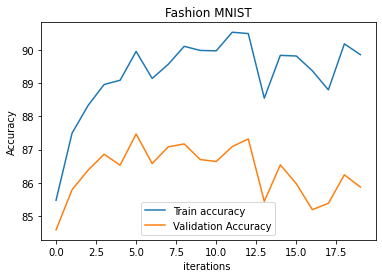

In [10]:
# Plot learning curve (with errors)

trainacc= np.squeeze(mce_fmnist_train_acc)
valacc = np.squeeze(mce_fmnist_train_valacc)
plt.plot(mce_fmnist_train_acc,label ='Train accuracy')
plt.plot(valacc,label ='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('iterations ')
plt.title("Fashion MNIST")
plt.legend()
plt.show()

#Train for pre Activation model

In [ ]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_gpu_pre = MLP_Pre(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
mce_fmnist_train_pre=[]
mce_fmnist_train_acc_pre=[]
mce_fmnist_train_valacc_pre=[]
time_start = time.time()
print("For Fashion MNIST GPU\n")
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(100)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_gpu_pre.forward(inputs,True) 
    loss_total = loss_total + mlp_on_gpu_pre.loss(preds, outputs)
    lt = lt + mlp_on_gpu_pre.loss(preds, outputs)
    mlp_on_gpu_pre.backward(inputs, outputs)

  mce_fmnist_train_pre.append(np.sum(loss_total) / X_train.shape[0])
  preds = mlp_on_gpu_pre.forward(X_train,False)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  mce_fmnist_train_acc_pre.append(ds*100)
  #print('\nTrain Accuracy: {:.4f}'.format(ds))
  #print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_gpu_pre.forward(X_val,False)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()
  mce_fmnist_train_valacc_pre.append(cur_val_acc*100)
  #print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  print('Number of Epoch = {} - Average Cross Entropy:= {} - Validation Accuracy: {:.4f} - Train Accuracy: {:.4f} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0],cur_val_acc*100,ds*100))
  #plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))


For Fashion MNIST GPU

Number of Epoch = 1 - Average Cross Entropy:= 0.5371693359375 - Validation Accuracy: 85.1800 - Train Accuracy: 86.0200 
Number of Epoch = 2 - Average Cross Entropy:= 0.4559314453125 - Validation Accuracy: 83.7400 - Train Accuracy: 84.7560 
Number of Epoch = 3 - Average Cross Entropy:= 0.547106484375 - Validation Accuracy: 84.1800 - Train Accuracy: 85.1660 
Number of Epoch = 4 - Average Cross Entropy:= 0.6854546875 - Validation Accuracy: 83.9500 - Train Accuracy: 85.0220 


In [ ]:
# Plot learning curve for pre activation(with accuracy)

trainacc= np.squeeze(mce_fmnist_train_acc_pre)
valacc = np.squeeze(mce_fmnist_train_valacc_pre)
plt.plot(mce_fmnist_train_acc,label ='Train accuracy')
plt.plot(valacc,label ='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('iterations ')
plt.title("Fashion MNIST")
plt.legend()
plt.show()

In [ ]:
#ploting for loss for both pre and post Activation BN models
# Plot learning curve (with errors)

postmodelerror= np.squeeze(mce_fmnist_train)
premodelerror = np.squeeze(mce_fmnist_train_pre)
plt.plot(postmodelerror,label ='Post Activation BN')
plt.plot(premodelerror,label ='Pre Activation BN')
plt.ylabel('Error Losses')
plt.xlabel('iterations ')
plt.title("Fashion MNIST")
plt.legend()
plt.show()

#Saving your model weights or parameters
* It is always advisable to save your model checkpoints every k epochs.
* Look at Saver object in tensorflow/keras.
* Visualize your model performance using tensorboard.

#Steps to save model weights using pickle
* Save your model(trainable variables), in our case self.variables into a pickle file.
* Load saved file
* Redefine model
* Load weights
* Re-train or test your model

In [ ]:
#saving models for BN
import pickle
models = [MLP, MLP_Pre,]
files = ["MLP_Post.pickle", "MLP_Pre.pickle"]
for model, f in zip(models, files):
  vars = model.variables
  with open(f, 'wb') as handle:
    pickle.dump(vars, handle)

In [ ]:
#Loading from saved variables
with open('MLP_Post.pickle', 'rb') as handle:
    b = pickle.load(handle)

#Loading from saved variables
with open('MLP_Pre.pickle', 'rb') as handle:
    b = pickle.load(handle)


In [ ]:
print("For Fashion MNIST inference for post Activation BN\n")
#list to store inferences of test for 10 seeds
inference_fmnist=[]

##accuracy
inference_fmnist_acc=[]

Inferences_seeds=[5097,1111,1234,5678,199991,99999,3421,6642,8754,3454444]
for seed in Inferences_seeds:
  print("For seed:{}\n".format(seed))
  # Initialize
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)


  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = mlp_on_gpu.forward(inputs,True)
    test_loss_total = test_loss_total + mlp_on_gpu.loss(preds, outputs)
  print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

  # Test model
  preds_test = mlp_on_gpu.forward(X_test,False)
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  inference_fmnist.append(np.sum(test_loss_total.numpy()) / X_test.shape[0])
  inference_fmnist_acc.append(cur_test_acc)
  print('Test loss: {:.4f} - Test Accuracy:{:.2f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0],cur_test_acc))

In [ ]:
with open('weights_pre.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [ ]:
print("For Fashion MNIST inference for Pre Activation BN\n")
#list to store inferences of test for 10 seeds
inference_fmnist_pre=[]

##accuracy
inference_fmnist_acc_pre=[]

Inferences_seeds=[5097,1111,1234,5678,199991,99999,3421,6642,8754,3454444]
for seed in Inferences_seeds:
  print("For seed:{}\n".format(seed))
  # Initialize
  test_loss_total = tf.Variable(0, dtype=tf.float32)
  correct_prediction = tf.Variable(0, dtype=tf.float32)


  test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


  #test_loss_total = 0.0
  for inputs, outputs in test_ds:
    preds = mlp_on_gpu_pre.forward(inputs,True)
    test_loss_total = test_loss_total + mlp_on_gpu_pre.loss(preds, outputs)
  print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

  # Test model
  preds_test = mlp_on_gpu_pre.forward(X_test,False)
  preds_test = tf.nn.softmax(preds_test)
  correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_test_acc = accuracy.numpy()
  inference_fmnist_pre.append(np.sum(test_loss_total.numpy()) / X_test.shape[0])
  inference_fmnist_acc_pre.append(cur_test_acc)
  print('Test loss: {:.4f} - Test Accuracy:{:.2f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0],cur_test_acc))

In [ ]:
# Plot learning curve for pre activation(with error)
plt.figure(1)
testmodelerror= np.squeeze(inference_fmnist)
testpremodelerror = np.squeeze(inference_fmnist_pre)
plt.plot(testmodelerror,label ='Test post model error')
plt.plot(testpremodelerror,label ='Test pre model error')
plt.ylabel('Error')
plt.xlabel('iterations ')
plt.title("Test Fashion MNIST")
plt.legend()
plt.show()
# Plot learning curve for pre activation(with error)
plt.figure(2)
testacc= np.squeeze(inference_fmnist_acc)
testpreacc = np.squeeze(inference_fmnist_acc_pre)
plt.plot(testacc,label ='Test post BN accuracy')
plt.plot(testpreacc,label ='Test Pre BN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('iterations ')
plt.title("Test Fashion MNIST")
plt.legend()
plt.show()